# Imports

In [3]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import image_dataset_from_directory

import os
import imghdr

# Limiting GPU usage for TensorFlow

In [4]:
gpus = tf.config.list_physical_devices("GPU")
for i in gpus:
    tf.config.experimental.set_memory_growth(i, True)

# Getting rid of invalid images 

In [5]:
img_folder = "images"
img_extensions = ["jpeg", "jpg", "png", "bmp"]

In [145]:
for image_class in os.listdir(img_folder):
    if not image_class == ".DS_Store":
        for image in os.listdir(os.path.join(img_folder,image_class)):
            img_path = os.path.join(img_folder, image_class, image)
            
            try:
                img = cv2.imread(img_path)
                ext = imghdr.what(img_path) 

                if not ext in img_extensions:
                    print(f"Image extenstion is bad: {img_path}")
                    os.remove(img_path)
            except:
                print(f"Image could not be open: {img_path}")
                os.remove(img_path)

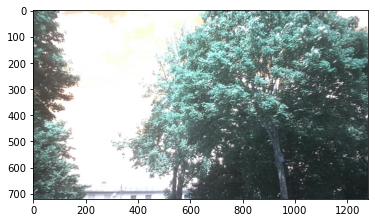

In [ ]:
image = cv2.imread("images/clear_sky/2022-05-24 12:53:30.738337.jpg")
plt.imshow(image);

# Converting data to a database

In [ ]:
data = image_dataset_from_directory(img_folder, batch_size=3)
data

Found 4 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# Creating a data iterator
data_iterator = data.as_numpy_iterator()

In [ ]:
# Creating batches of images
batch = data_iterator.next()
batch[1]

array([1, 1, 0], dtype=int32)

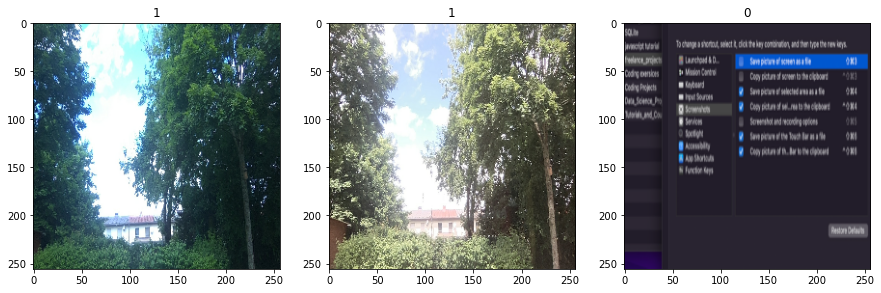

In [ ]:
# Visualizing some of our images
fig, ax = plt.subplots(ncols=3, figsize=(15,7))
for i, img in enumerate(batch[0][:]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])


# Scaling Down Images

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
batch = data.as_numpy_iterator().next()